In [1]:
%pylab inline
import pandas as pd
import numpy as np
import seaborn as sns
from collections import OrderedDict
import itertools

Populating the interactive namespace from numpy and matplotlib


Some global settings:

In [2]:
filepath = '/home/romina/Arbeitsfläche/Models/LimnoSES/public/simdata'

In [3]:
matplotlib.rcParams['font.weight'] = 'bold'

In [4]:
sns.set()
sns.set_style('whitegrid')

# Result figures for navigation through regime shifts

Specification parameter ranges that were varied over the different simualations.

In [5]:
runs = range(1, 21, 1) # just a counter for repetitions
experiments = ['homoOwners','homoOwnersSocial','homoOwnersEnforced'] # social strategies - coded by colors
#wtus = np.arange(0.1, 0.35, 0.1)
#wtus = (0.1, 0.19, 0.2, 0.21, 0.3) # willingness to upgrade - should be coded in plots by linestyles
#wtus = (0.1, 0.2, 0.3)
wtus = (0.18, 0.2, 0.22)

# the critical threshold crossed that triggers the start of regulation 
#nutrCriticals = (2, 2.3, 2.4, 2.5, 3, 3.5)
#nutrCriticals = (2, 2.3, 2.4, 2.5, 2.6, 3, 3.5, 4) # coded by markers, markersize
nutrCriticals = (2.25, 2.5, 2.75) # for local SA
nutrInit = 0.7 # the initial nutrient value that the simulation starts from and ends

## Loading the experiments

In [6]:
# scenario evaluation parameters
pikeCrit = 1.5
evalRange = 60 # time scale to evaluate restoration effects

In [7]:
a = [] # to collect subset data frames
b = [] # to collect whole time series
c = [] # to collect time lag data

subsetrange = evalRange
for experiment in experiments: 
    for wtu, nutrient, j in \
            itertools.product(wtus, nutrCriticals, runs):

        if (nutrient == 3.5 or nutrient == 4) and (wtu == 0.19 or wtu == 0.21):  # these combinations did not run
            continue
        if (nutrient == 2.3) and (j > 10): # no more than 10 runs available
            continue

        # calling data from 2016, 12.02.
        filename = filepath+'/SewageDRestore_Scen'+str(experiment)+'_w'+str(wtu)+'_n0'+str(nutrInit)+'_n'+str(nutrient)+'_R'+str(j)+'_annual.csv'
        df_years = pd.read_csv(filename, index_col=(0), na_values='none')
        try:
            del df_years[' ']
        except KeyError:
            print('Key Error empty column: ', filename)
            continue
        
        if df_years.size == 0:
            print('Empty subset from: ', filename)
            continue

        # identify years with events and calculate time lags
        dict_lags = OrderedDict() # to build rowwise data frame
        dict_lags['yTip1'] = df_years[df_years['nutrients']>=2.1].index.min() # first tip from clear to turbid
        dict_lags['yInformed'] = df_years[df_years['upgraded households']>0].index.min() - 1  # year when houseowners were informed about necessary update
        dict_lags['yRestoredHalf'] = df_years[df_years['upgraded households']>=50].index.min()
        dict_lags['yRestored'] = df_years[df_years['upgraded households']>=95].index.min() # year when 95 houseowners upgraded
        df_sub2 = df_years[df_years['upgraded households']> 0]
        dict_lags['yTip2']  = df_sub2[df_sub2['nutrients']<0.9].index.min() # 2nd tip, now back to clear
        
        df_rest = df_years.loc[df_years[df_years['pike']<1.5].index.min():, :]
        dict_lags['yPikeBack'] = df_rest[df_rest['pike']>1.5].index.min()
        dict_lags['socialResponseLag'] = dict_lags['yRestored'] - dict_lags['yTip1']
        dict_lags['ecologicalResponseLagPure'] = dict_lags['yPikeBack'] - dict_lags['yRestoredHalf']
        dict_lags['ecologicalResponseLag'] = dict_lags['yPikeBack'] - dict_lags['yRestored']

        # create subset of timeseries for restoration time
        try:
            # select the first subsetrange (60) rows after the first households started upgrading
            subset = df_years[df_years['upgrade-efficiency'] > 0].iloc[0:subsetrange,(2,1)].reset_index()
        except KeyError:
            print('Key Error upgrade efficiency: ', filename)
            continue

        if size(subset) == 0:
            print('Empty subset from: ', filename)
            continue

        subset.columns = ['yearIndex', 'nutrients', 'pike']
        # calculate the differences to thresholds
        subset['nutrient_diff'] = subset['nutrients'] - nutrInit
        subset['pike_diff'] = subset['pike'] - pikeCrit

        # add the columns that become indices later
        subset['run'] = pd.Series(j, index=subset.index)
        subset['wtu'] = pd.Series(wtu, index=subset.index)
        subset['experiment'] = pd.Series(experiment, index=subset.index)
        subset['nutrCrit'] = pd.Series(nutrient, index=subset.index)
        subset['year'] = pd.Series(np.arange(subsetrange), index=subset.index)
        a.append(subset)

        # now for the whole annual time series
        #del df_years['upgrade-efficiency']
        #del df_years['upgraded households']
        df_years['run'] = pd.Series(j, index=df_years.index)
        df_years['wtu'] = pd.Series(wtu, index=df_years.index)
        df_years['experiment'] = pd.Series(experiment, index=df_years.index)
        df_years['nutrCrit'] = pd.Series(nutrient, index=df_years.index)
        b.append(df_years)

        # add indice columns
        dict_lags['run'] = j
        dict_lags['wtu'] = wtu
        dict_lags['experiment'] = experiment
        dict_lags['nutrCrit'] = nutrient
        c.append(dict_lags)
    print('Experiment loaded: ', experiment)

Experiment loaded:  homoOwners
Experiment loaded:  homoOwnersSocial
Experiment loaded:  homoOwnersEnforced


Now putting the list of experiments together in one dataframe, first for the complete time series, then for the restoration subset with calculated distances from nutrient and pike thresholds

In [8]:
timelags = pd.DataFrame(c, columns = dict_lags.keys())
timelags.set_index(['run', 'wtu', 'experiment', 'nutrCrit'], append=True, inplace=True)
timelags.head()

yTip1  yInformed  yRestoredHalf  yRestored  \
  run wtu  experiment nutrCrit                                               
0 1   0.18 homoOwners 2.25         15         16             20         34   
1 2   0.18 homoOwners 2.25         15         16             21         33   
2 3   0.18 homoOwners 2.25         15         16             20         32   
3 4   0.18 homoOwners 2.25         15         16             19         32   
4 5   0.18 homoOwners 2.25         15         16             20         30   

                                yTip2  yPikeBack  socialResponseLag  \
  run wtu  experiment nutrCrit                                        
0 1   0.18 homoOwners 2.25         42         65                 19   
1 2   0.18 homoOwners 2.25         42         65                 18   
2 3   0.18 homoOwners 2.25         40         61                 17   
3 4   0.18 homoOwners 2.25         40         59                 17   
4 5   0.18 homoOwners 2.25         41         64                 15   

                                ecologicalResponseLagPure  \
  run wtu  experiment nutrCrit                              
0 1   0.18 homoOwners 2.25                             45   
1 2   0.18 homoOwners 2.25                             44   
2 3   0.18 homoOwners 2.25                             41   
3 4   0.18 homoOwners 2.25                             40   
4 5   0.18 homoOwners 2.25                             44   

                                ecologicalResponseLag  
  run wtu  experiment nutrCrit                         
0 1   0.18 homoOwners 2.25                         31  
1 2   0.18 homoOwners 2.25                         32  
2 3   0.18 homoOwners 2.25                         29  
3 4   0.18 homoOwners 2.25                         27  
4 5   0.18 homoOwners 2.25                         34

In [9]:
timeseries = pd.concat(b)
timeseries.set_index(['run', 'wtu', 'experiment', 'nutrCrit'], append=True, inplace=True)

differences = pd.concat(a)
differences.set_index(['run', 'wtu', 'experiment', 'nutrCrit', 'year'], inplace=True)

In [10]:
timeseries.head()

bream      pike  nutrients  vegetation  \
year run wtu  experiment nutrCrit                                               
1    1   0.18 homoOwners 2.25      20.000000  1.800000        0.7   50.000000   
2    1   0.18 homoOwners 2.25      21.678942  1.795731        0.8   45.978252   
3    1   0.18 homoOwners 2.25      24.287194  1.867367        0.9   40.409437   
4    1   0.18 homoOwners 2.25      26.867411  1.992500        1.0   35.655144   
5    1   0.18 homoOwners 2.25      28.832254  2.135277        1.1   32.486020   

                                   upgrade-efficiency  upgraded households  \
year run wtu  experiment nutrCrit                                            
1    1   0.18 homoOwners 2.25                       0                    0   
2    1   0.18 homoOwners 2.25                       0                    0   
3    1   0.18 homoOwners 2.25                       0                    0   
4    1   0.18 homoOwners 2.25                       0                    0   
5    1   0.18 homoOwners 2.25                       0                    0   

                                   sewage water  
year run wtu  experiment nutrCrit                
1    1   0.18 homoOwners 2.25               0.1  
2    1   0.18 homoOwners 2.25               0.1  
3    1   0.18 homoOwners 2.25               0.1  
4    1   0.18 homoOwners 2.25               0.1  
5    1   0.18 homoOwners 2.25               0.1

### Load hysteresis curve

See more details in LoadingHysteresisCurve.ipynb

In [11]:
filepath = '/home/romina/Arbeitsfläche/Models/LimnoSES/'
filename = 'LimnoSES.dat'
df_hyst = pd.read_csv(filepath+filename, na_values='none', delimiter = '\t') 

In [12]:
df_subset = df_hyst.loc[:626,:]
df_subset2 = df_subset.loc[278:,:]

## 1 Figures for validation 

Now creating suitable subsets of data for plotting.

In [35]:
subseries1 = timeseries.xs(('homoOwners', 0.2),level=('experiment', 'wtu')).reset_index()

In [36]:
subseries1_grouped = differences.xs(('homoOwners', 0.2),level=('experiment', 'wtu')).groupby(level = 'nutrCrit')

Finding the onset of restauration:

In [37]:
subseries1_grouped['yearIndex'].min()

nutrCrit
2.0    15
2.3    17
2.5    20
2.7    21
3.0    24
Name: yearIndex, dtype: int64

### a) Time series showing the eutrophication and restoration

Differentiating between optimal, intermediate and negative example of a regulation response by varying the criticial nutrient threshold. 

In [38]:
myd = subseries1[(subseries1.nutrCrit == 2) | (subseries1.nutrCrit == 2.5) | (subseries1.nutrCrit == 3) ]
#myd = subseries1[(subseries1.nutrCrit == 2) | (subseries1.nutrCrit == 2.3) | (subseries1.nutrCrit == 2.5) | (subseries1.nutrCrit == 3) | (subseries1.nutrCrit == 3.5) | (subseries1.nutrCrit == 4)]

/home/romina/.local/lib/python3.5/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


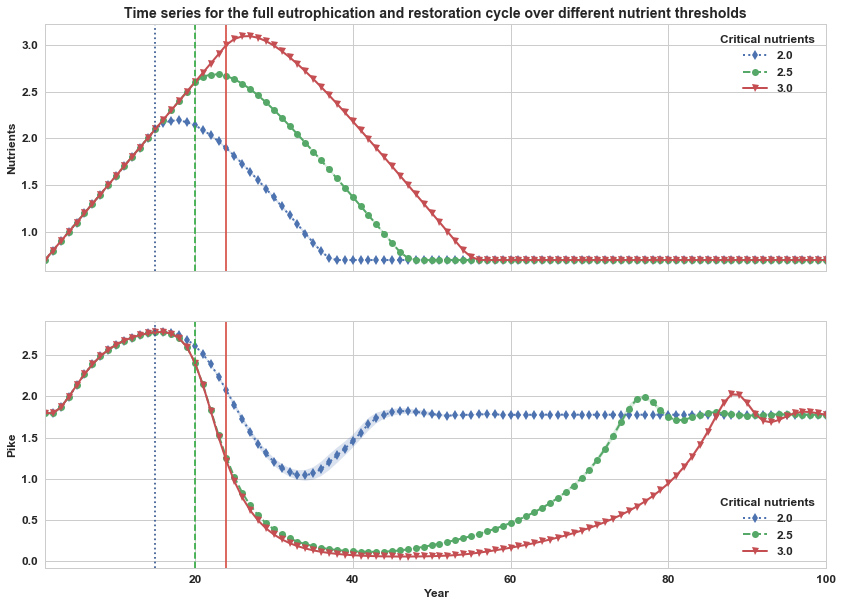

In [39]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(14,10))

#styles = ['bd-','bs-','bv-']
#for style in zip(styles):
g1 = sns.tsplot(time="year", value="nutrients", unit="run", condition="nutrCrit", data=myd,
                ax = ax1, linestyle = '--', linewidth = 2)
# color = sns.xkcd_rgb["denim blue"]
g2 = sns.tsplot(time="year", value="pike", unit="run", condition="nutrCrit", data=myd,
                ax = ax2, linestyle = '--', linewidth = 2)

# some post-hoc manipulations
g1.lines[-1].set_marker("v")
g1.lines[1].set_marker("o")
g1.lines[0].set_marker("d")
g1.lines[0].set_linestyle(":")
g1.lines[-1].set_linestyle("-")
g2.lines[-1].set_marker("v")
g2.lines[1].set_marker("o")
g2.lines[0].set_marker("d")
g2.lines[0].set_linestyle(":")
g2.lines[-1].set_linestyle("-")
ax1.axvline(x=15, ls=":", color = sns.xkcd_rgb["denim blue"])
ax1.axvline(x=20, ls="--", color = sns.xkcd_rgb["medium green"])
ax1.axvline(x=24, color = sns.xkcd_rgb["pale red"])
ax2.axvline(x=15, ls=":", color = sns.xkcd_rgb["denim blue"])
ax2.axvline(x=20, ls="--", color = sns.xkcd_rgb["medium green"])
ax2.axvline(x=24, color = sns.xkcd_rgb["pale red"])
g1.legend(title='Critical nutrients', fontsize=12)
g2.legend(title='Critical nutrients', fontsize=12)

ax1.set_title('Time series for the full eutrophication and restoration cycle over different nutrient thresholds'
              , fontsize = 14, fontweight = 'bold')
ax1.set_xlabel('')
ax2.set_xlabel('Year', fontsize = 12, fontweight = 'bold')
ax2.tick_params(labelsize = 12)
ax1.set_ylabel('Nutrients', fontsize = 12, fontweight = 'bold')
ax2.set_ylabel('Pike', fontsize = 12, fontweight = 'bold')
ax1.tick_params(labelsize = 12)

#plt.savefig("images/NavigatingRSFig1a_lake_17.pdf")

### b) Time series showing household upgrades

Just to demonstrate the effect from the three social strategies

In [ ]:
subseries2 = timeseries.xs((2.5, 0.2),level=('nutrCrit', 'wtu')).reset_index()
myd2 = subseries2[subseries2['year'] > 14]
myd2 = myd2[myd2['year'] < 45]

In [ ]:
subseries2 = timeseries.xs((2.5, 0.2),level=('nutrCrit', 'wtu')).reset_index()
myd2 = subseries2[subseries2['year'] > 14]
myd2 = myd2[myd2['year'] < 45]

subseries3 = timeseries.xs((2.5, 0.18),level=('nutrCrit', 'wtu')).reset_index()
myd3 = subseries3[subseries3['year'] > 14]
myd3 = myd3[myd3['year'] < 45]

subseries4 = timeseries.xs((2.5, 0.22),level=('nutrCrit', 'wtu')).reset_index()
myd4 = subseries4[subseries4['year'] > 14]
myd4 = myd4[myd4['year'] < 45]

In [ ]:
subseries2 = timeseries.xs((2.5, 0.2),level=('nutrCrit', 'wtu')).reset_index()
myd2 = subseries2[subseries2['year'] > 14]
myd2 = myd2[myd2['year'] < 45]

In [ ]:
g = sns.tsplot(time="year", value="upgraded households", unit="run", condition="experiment", data=myd2,
                linestyle = '--', linewidth = 2, marker = 'o')

g.set_xlabel('Year', fontsize = 12, fontweight = 'bold')
g.set_ylabel('Upgraded households', fontsize = 12, fontweight = 'bold')
g.lines[-1].set_marker("v")
g.lines[1].set_marker("o")
g.lines[0].set_marker("d")
g.lines[0].set_linestyle(":")
g.lines[-1].set_linestyle("-")
g.axhline(y=100, ls=":", color = sns.xkcd_rgb["denim blue"])
g.legend(('No enforcement','Social pressure','Central enforcement'), title='Experiment', fontsize=12, 
         loc="lower right")
#plt.savefig("images/NavigatingRSFig1b_upgrades.pdf")

In [ ]:
subseries2 = timeseries.xs(('homoOwnersEnforced', 0.2),level=('experiment', 'wtu')).reset_index()
myd2 = subseries2[subseries2['year'] > 10]
myd2 = myd2[myd2['year'] < 50]

In [ ]:
g = sns.tsplot(time="year", value="upgraded households", unit="run", condition="nutrCrit", data=myd2,
                linestyle = '--', linewidth = 2, marker = 'o')
g.set_title("homoOwners-enforced upgrade")
plt.savefig("images/HouseholdUpgrades_nutrCrit_enforced.pdf")

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15,5))
g1 = sns.tsplot(time="year", value="upgraded households", unit="run", condition="experiment", data=myd3, ax = ax1,
                linestyle = '--', linewidth = 2, marker = 'o')

g2 = sns.tsplot(time="year", value="upgraded households", unit="run", condition="experiment", data=myd2, ax = ax2,
                linestyle = '--', linewidth = 2, marker = 'o')

g3 = sns.tsplot(time="year", value="upgraded households", unit="run", condition="experiment", data=myd4, ax = ax3,
                linestyle = '--', linewidth = 2, marker = 'o')

g2.set_xlabel('Year', fontsize = 12, fontweight = 'bold')
g1.set_ylabel('Upgraded households', fontsize = 12, fontweight = 'bold')
g1.axhline(y=100, ls=":", color = sns.xkcd_rgb["denim blue"])
g1.legend('')
g2.legend('')
#g3.legend(('No reinforcement','Social engagement','Central enforcement'), title='Experiment', 
         #fontsize=12, loc="lower right")
#g1.set_title('Time series for the upgrades of private sewage treatment systems by houseowners'
              #, fontsize = 14, fontweight = 'bold')

plt.savefig("images/NavigatingRSFig1b_upgrades2.pdf")

##  2 Local sensitivity analysis of restoration against different social drivers

### a) Restoration effect ~ critical nutrient threshold 

In [ ]:
subseries1_homo = differences.xs(('homoOwners', 0.2),level=('experiment', 'wtu')).reset_index()
myd3 = subseries1_homo[(subseries1_homo.nutrCrit == 2.3) | (subseries1_homo.nutrCrit == 2.4) |
                       (subseries1_homo.nutrCrit == 2.5)]

In [ ]:
sub1states_nCrit = differences.xs(('homoOwners', 0.2),
                                  level=('experiment', 'wtu')).groupby(level = ['nutrCrit','year']).mean().reset_index() 
myd4 = sub1states_nCrit[(sub1states_nCrit.nutrCrit == 2.3) | (sub1states_nCrit.nutrCrit == 2.4) | 
                        (sub1states_nCrit.nutrCrit == 2.5)]

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=False, figsize=(8,15))

g1 = sns.tsplot(time="year", value="nutrients", unit="run", condition="nutrCrit", data=myd3,
                ax = ax1, linestyle = '--', linewidth = 2)
# color = sns.xkcd_rgb["denim blue"]
g2 = sns.tsplot(time="year", value="pike", unit="run", condition="nutrCrit", data=myd3,
                ax = ax2, linestyle = '--', linewidth = 2)

ax3.plot(df_hyst.nutrients, df_hyst['pike-stock'], color = 'gray' , linewidth = 1)
ax3.plot(df_subset2['nutrients'], df_subset2['pike-stock'], 'k--', linewidth = 2)
ax3.plot(myd4.nutrients[myd4.nutrCrit == 2.3], myd4.pike[myd4.nutrCrit == 2.3], 
         marker='o', ms = 8, linestyle = ':')
ax3.plot(myd4.nutrients[myd4.nutrCrit == 2.4], myd4.pike[myd4.nutrCrit == 2.4],
         marker='o', ms = 6, linestyle = '--')
ax3.plot(myd4.nutrients[myd4.nutrCrit == 2.5], myd4.pike[myd4.nutrCrit == 2.5],
         marker='o', ms = 4, linestyle = '-')

# some post-hoc manipulations
g1.lines[-1].set_marker("o")
g1.lines[-1].set_markersize(4)
g1.lines[1].set_marker("o")
g1.lines[0].set_marker("o")
g1.lines[0].set_markersize(8)
g1.axhline(y=0.7, ls=":", color = sns.xkcd_rgb["denim blue"])
g2.lines[-1].set_marker("o")
g2.lines[-1].set_markersize(4)
g2.lines[1].set_marker("o")
g2.lines[0].set_marker("o")
g2.lines[0].set_markersize(8)
#g2.axhline(y=1.6, ls=":", color = sns.xkcd_rgb["denim blue"])
g1.legend(title='Critical nutrients', fontsize=12)
g2.legend('')

ax1.set_title('Time series for the restoration after crossing different nutrient thresholds'
              , fontsize = 14, fontweight = 'bold')
ax1.set_xlabel('')
ax2.set_xlabel('Year', fontsize = 12, fontweight = 'bold')
ax1.set_ylabel('Nutrients', fontsize = 12, fontweight = 'bold')
ax2.set_ylabel('Pike', fontsize = 12, fontweight = 'bold')
ax3.set_xlabel('Nutrients', fontsize = 12, fontweight = 'bold')
ax3.set_ylabel('Pike', fontsize = 12, fontweight = 'bold')
ax3.set_xlim([0.5,3])
ax3.legend(('Stable states', 'Unstable states'), loc='upper left')

plt.savefig("images/NavigatingRSFig2nutrients_a.pdf")

-> Restoration success is more sensitive towards timing (Fig. 2a) than the initial motivation for the update (Fig. 2b).

### e) SA PNAS

First, show qualitative difference between how time lags affect lake restoration (3 parameters to change):

In [13]:
sub1states_nCrit = differences.xs(
    ('homoOwners', 0.2), level=('experiment', 'wtu'))\
    .groupby(level = ['nutrCrit','year']).mean()
sub1states_nCrit.head()

yearIndex  nutrients      pike  nutrient_diff  pike_diff
nutrCrit year                                                          
2.25     0            17     2.3000  2.763333         1.6000   1.263333
         1            18     2.3595  2.710947         1.6595   1.210947
         2            19     2.3867  2.612448         1.6867   1.112448
         3            20     2.3882  2.457546         1.6882   0.957546
         4            21     2.3708  2.245629         1.6708   0.745629

In [14]:
nCrit = sub1states_nCrit[(sub1states_nCrit.nutrients < 0.9) & (sub1states_nCrit.pike > 1.5)]\
    .groupby(level = ['nutrCrit']).head(1)
nCrit

yearIndex  nutrients      pike  nutrient_diff  pike_diff
nutrCrit year                                                          
2.25     42           59        0.7  1.617524              0   0.117524
2.50     53           73        0.7  1.521971              0   0.021971
2.75     58           80        0.7  1.579684              0   0.079684

In [15]:
sub1states_wtu = differences.xs(('homoOwners', 2.5),
    level=('experiment', 'nutrCrit')).groupby(level = ['wtu','year']).mean()

In [16]:
sub1states_exp = differences.xs((2.5, 0.2),
    level=('nutrCrit', 'wtu')).groupby(level = ['experiment','year']).mean()

In [21]:
sub1states_nCrit = sub1states_nCrit.reset_index() 
myd4 = sub1states_nCrit[(sub1states_nCrit.nutrCrit == 2.25) | (sub1states_nCrit.nutrCrit == 2.5) | 
                        (sub1states_nCrit.nutrCrit == 2.75)]

In [18]:
sub1states_wtu = sub1states_wtu.reset_index() 
myd5 = sub1states_wtu[(sub1states_wtu.wtu == 0.18) | (sub1states_wtu.wtu == 0.2) | 
                        (sub1states_wtu.wtu == 0.22)]

In [19]:
sub1states_exp = sub1states_exp.reset_index() 
myd6 = sub1states_exp[(sub1states_exp.experiment == 'homoOwners') | (sub1states_exp.experiment == 'homoOwnersSocial') | 
                        (sub1states_exp.experiment == 'homoOwnersEnforced')]

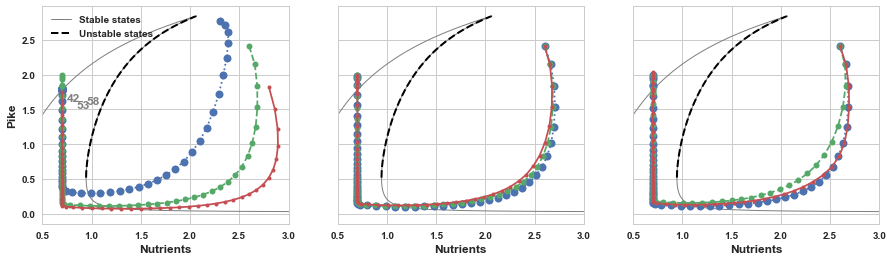

In [24]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(15,4))

for a in ax:
    a.plot(df_hyst.nutrients, df_hyst['pike-stock'], color = 'gray' , linewidth = 1)
    a.plot(df_subset2['nutrients'], df_subset2['pike-stock'], 'k--', linewidth = 2)
    
ax[0].plot(myd4.nutrients[myd4.nutrCrit == 2.25], myd4.pike[myd4.nutrCrit == 2.25], 
         marker='o', ms = 8, linestyle = ':')
ax[0].plot(myd4.nutrients[myd4.nutrCrit == 2.5], myd4.pike[myd4.nutrCrit == 2.5],
         marker='o', ms = 6, linestyle = '--')
ax[0].plot(myd4.nutrients[myd4.nutrCrit == 2.75], myd4.pike[myd4.nutrCrit == 2.75],
         marker='o', ms = 4, linestyle = '-')

xshift = 0.75
for i in nCrit.reset_index()[['year','pike']].itertuples():
    ax[0].text(xshift, i.pike, i.year, horizontalalignment='left', color='grey')
    xshift += 0.1

ax[1].plot(myd5.nutrients[myd5.wtu == 0.18], myd5.pike[myd5.wtu == 0.18], 
         marker='o', ms = 8, linestyle = ':')
ax[1].plot(myd5.nutrients[myd5.wtu == 0.2], myd5.pike[myd5.wtu == 0.2],
         marker='o', ms = 6, linestyle = '--')
ax[1].plot(myd5.nutrients[myd5.wtu == 0.22], myd5.pike[myd5.wtu == 0.22],
         marker='o', ms = 4, linestyle = '-')

ax[2].plot(myd6.nutrients[myd6.experiment == 'homoOwners'], myd6.pike[myd6.experiment == 'homoOwners'], 
         marker='o', ms = 8, linestyle = ':')
ax[2].plot(myd6.nutrients[myd6.experiment == 'homoOwnersSocial'], myd6.pike[myd6.experiment == 'homoOwnersSocial'],
         marker='o', ms = 6, linestyle = '--')
ax[2].plot(myd6.nutrients[myd6.experiment == 'homoOwnersEnforced'], myd6.pike[myd6.experiment == 'homoOwnersEnforced'],
         marker='o', ms = 4, linestyle = '-')

ax[0].set_ylabel('Pike', fontsize = 12, fontweight = 'bold')
ax[0].legend(('Stable states', 'Unstable states'), loc='upper left')
for a in ax:
    a.set_xlim([0.5,3])
    a.set_xlabel('Nutrients', fontsize = 12, fontweight = 'bold')

plt.savefig("../images/NavigatingRS_SA2018.pdf")

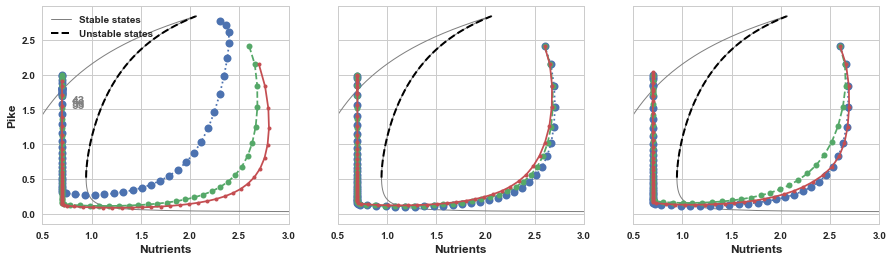

In [99]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,4))

ax1.plot(df_hyst.nutrients, df_hyst['pike-stock'], color = 'gray' , linewidth = 1)
ax1.plot(df_subset2['nutrients'], df_subset2['pike-stock'], 'k--', linewidth = 2)
ax1.plot(myd4.nutrients[myd4.nutrCrit == 2.3], myd4.pike[myd4.nutrCrit == 2.3], 
         marker='o', ms = 8, linestyle = ':')
ax1.plot(myd4.nutrients[myd4.nutrCrit == 2.5], myd4.pike[myd4.nutrCrit == 2.5],
         marker='o', ms = 6, linestyle = '--')
ax1.plot(myd4.nutrients[myd4.nutrCrit == 2.7], myd4.pike[myd4.nutrCrit == 2.7],
         marker='o', ms = 4, linestyle = '-')

for i in nCrit.reset_index()[['year','pike']].itertuples():
   ax1.text(0.8, i.pike, i.year, horizontalalignment='left', color='grey')

ax2.plot(df_hyst.nutrients, df_hyst['pike-stock'], color = 'gray' , linewidth = 1)
ax2.plot(df_subset2['nutrients'], df_subset2['pike-stock'], 'k--', linewidth = 2)
ax2.plot(myd5.nutrients[myd5.wtu == 0.18], myd5.pike[myd5.wtu == 0.18], 
         marker='o', ms = 8, linestyle = ':')
ax2.plot(myd5.nutrients[myd5.wtu == 0.2], myd5.pike[myd5.wtu == 0.2],
         marker='o', ms = 6, linestyle = '--')
ax2.plot(myd5.nutrients[myd5.wtu == 0.22], myd5.pike[myd5.wtu == 0.22],
         marker='o', ms = 4, linestyle = '-')

ax3.plot(df_hyst.nutrients, df_hyst['pike-stock'], color = 'gray' , linewidth = 1)
ax3.plot(df_subset2['nutrients'], df_subset2['pike-stock'], 'k--', linewidth = 2)
ax3.plot(myd6.nutrients[myd6.experiment == 'homoOwners'], myd6.pike[myd6.experiment == 'homoOwners'], 
         marker='o', ms = 8, linestyle = ':')
ax3.plot(myd6.nutrients[myd6.experiment == 'homoOwnersSocial'], myd6.pike[myd6.experiment == 'homoOwnersSocial'],
         marker='o', ms = 6, linestyle = '--')
ax3.plot(myd6.nutrients[myd6.experiment == 'homoOwnersEnforced'], myd6.pike[myd6.experiment == 'homoOwnersEnforced'],
         marker='o', ms = 4, linestyle = '-')

ax1.set_xlabel('Nutrients', fontsize = 12, fontweight = 'bold')
ax1.set_ylabel('Pike', fontsize = 12, fontweight = 'bold')
ax1.set_xlim([0.5,3])
ax1.legend(('Stable states', 'Unstable states'), loc='upper left')

ax2.set_xlabel('Nutrients', fontsize = 12, fontweight = 'bold')
ax2.set_xlim([0.5,3])

ax3.set_xlabel('Nutrients', fontsize = 12, fontweight = 'bold')
ax3.set_xlim([0.5,3])

plt.savefig("../images/NavigatingRS_Result2.pdf")

Attempts to show how far restoration worked until t_20:

In [29]:
myd4[myd4.nutrients < 0.9].head(2)

nutrCrit  year  yearIndex  nutrients      pike  nutrient_diff  pike_diff
23       2.3    23         40     0.8352  0.279567         0.1352  -1.220433
24       2.3    24         41     0.7442  0.294634         0.0442  -1.205366

In [49]:
myd4.pike[myd4.year == 20]

20     0.280779
80     0.120178
140    0.094322
Name: pike, dtype: float64

In [46]:
myd6.nutrients[myd5.year == 20]

20     1.3762
80     1.2287
140    1.1021
Name: nutrients, dtype: float64

Then, demonstrate how late responses can be compensated by quick implementation, or how early responses can be eaten up by slow implementation

In [36]:
sub4states_base = differences.xs((0.2, 2.5),
                                level=('wtu', 'nutrCrit')).groupby(level = ['experiment','year']).mean().reset_index()
sub4states_latefast = differences.xs((0.22, 2.7),
                                level=('wtu', 'nutrCrit')).groupby(level = ['experiment','year']).mean().reset_index()
sub4states_earlyslow = differences.xs((0.18, 2.3),
                                level=('wtu', 'nutrCrit')).groupby(level = ['experiment','year']).mean().reset_index()

(0.5, 3)

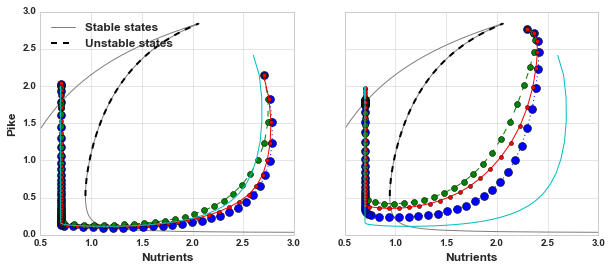

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,4))

ax1.plot(df_hyst.nutrients, df_hyst['pike-stock'], color = 'gray' , linewidth = 1)
ax1.plot(df_subset2['nutrients'], df_subset2['pike-stock'], 'k--', linewidth = 2)
ax1.plot(sub4states_latefast.nutrients[sub4states_latefast.experiment == 'homoOwners'], sub4states_latefast.pike[sub4states_latefast.experiment == 'homoOwners'], 
         marker='o', ms = 8, linestyle = ':')
ax1.plot(sub4states_latefast.nutrients[sub4states_latefast.experiment == 'homoOwnersSocial'], sub4states_latefast.pike[sub4states_latefast.experiment == 'homoOwnersSocial'],
         marker='o', ms = 6, linestyle = '--')
ax1.plot(sub4states_latefast.nutrients[sub4states_latefast.experiment == 'homoOwnersEnforced'], sub4states_latefast.pike[sub4states_latefast.experiment == 'homoOwnersEnforced'],
         marker='o', ms = 4, linestyle = '-')
ax1.plot(sub4states_base.nutrients[sub4states_base.experiment == 'homoOwners'], sub4states_base.pike[sub4states_base.experiment == 'homoOwners'],
         linestyle = '-')

ax2.plot(df_hyst.nutrients, df_hyst['pike-stock'], color = 'gray' , linewidth = 1)
ax2.plot(df_subset2['nutrients'], df_subset2['pike-stock'], 'k--', linewidth = 2)
ax2.plot(sub4states_earlyslow.nutrients[sub4states_earlyslow.experiment == 'homoOwners'], sub4states_earlyslow.pike[sub4states_earlyslow.experiment == 'homoOwners'], 
         marker='o', ms = 8, linestyle = ':')
ax2.plot(sub4states_earlyslow.nutrients[sub4states_earlyslow.experiment == 'homoOwnersSocial'], sub4states_earlyslow.pike[sub4states_earlyslow.experiment == 'homoOwnersSocial'],
         marker='o', ms = 6, linestyle = '--')
ax2.plot(sub4states_earlyslow.nutrients[sub4states_earlyslow.experiment == 'homoOwnersEnforced'], sub4states_earlyslow.pike[sub4states_earlyslow.experiment == 'homoOwnersEnforced'],
         marker='o', ms = 4, linestyle = '-')
ax2.plot(sub4states_base.nutrients[sub4states_base.experiment == 'homoOwners'], sub4states_base.pike[sub4states_base.experiment == 'homoOwners'],
         linestyle = '-')

ax1.set_xlabel('Nutrients', fontsize = 12, fontweight = 'bold')
ax1.set_ylabel('Pike', fontsize = 12, fontweight = 'bold')
ax1.set_xlim([0.5,3])
ax1.legend(('Stable states', 'Unstable states'), loc='upper left')

ax2.set_xlabel('Nutrients', fontsize = 12, fontweight = 'bold')
ax2.set_xlim([0.5,3])

Finally, demonstrate how the effectiveness of strategies switches depending on the wtu context

In [37]:
myd7_slow = differences.xs((0.22, 2.5),
                                level=('wtu', 'nutrCrit')).groupby(level = ['experiment','year']).mean().reset_index()
myd7_fast = differences.xs((0.18, 2.5),
                                level=('wtu', 'nutrCrit')).groupby(level = ['experiment','year']).mean().reset_index()

## 3 Quantifying restoration success ~ feedbacks

By determining the time within the unfavorable state and the distance to the desired state, we want to analyze to which extents the underlying feedbacks of social strategies can explain restoration outcome.

To which extent is the recovery of the desired state a function from the time, strength and initial condition of the restoration?

In [16]:
lags_nutr = timelags.xs((0.2),level=('wtu')).reset_index()

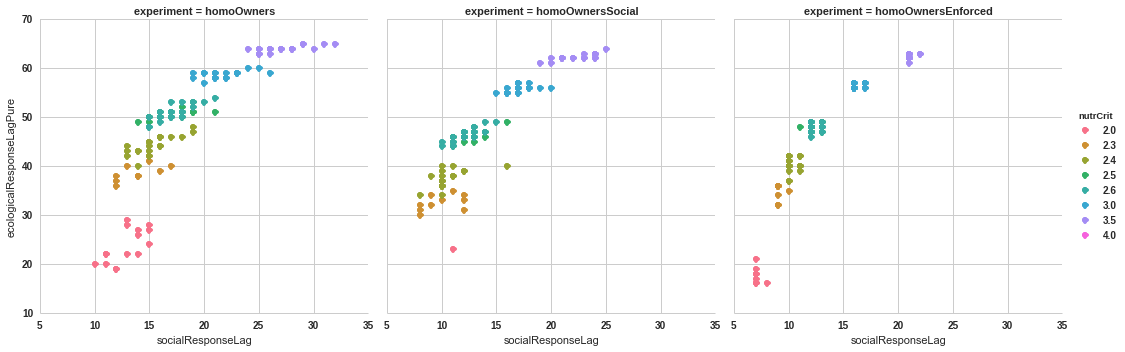

In [19]:
g = sns.FacetGrid(lags_nutr,  hue="nutrCrit", col = "experiment", size =5)
g = g.map(plt.plot, "socialResponseLag", "ecologicalResponseLagPure", marker='o', linestyle = '')
g.add_legend()
#plt.savefig("images/NavigatingRSFig3a-pure.pdf")

In [44]:
lags_nutr_grouped = timelags.xs((0.2),level=('wtu')).groupby(level=('nutrCrit','experiment')).mean().reset_index()
lags_nutr_grouped

nutrCrit          experiment  yTip1  yInformed  yRestoredHalf  yRestored  \
0        2.0          homoOwners     15         14      17.550000  27.650000   
1        2.0  homoOwnersEnforced     15         14      17.400000  22.150000   
2        2.0    homoOwnersSocial     15         14      16.900000  23.300000   
3        2.3          homoOwners     15         16      19.400000  29.000000   
4        2.3  homoOwnersEnforced     15         16      19.800000  24.200000   
5        2.3    homoOwnersSocial     15         16      18.800000  24.900000   
6        2.4          homoOwners     15         17      20.600000  30.450000   
7        2.4  homoOwnersEnforced     15         17      20.500000  25.350000   
8        2.4    homoOwnersSocial     15         17      19.850000  25.500000   
9        2.5          homoOwners     15         19      22.450000  32.200000   
10       2.5  homoOwnersEnforced     15         19      22.650000  27.100000   
11       2.5    homoOwnersSocial     15         19      21.750000  27.450000   
12       2.6          homoOwners     15         19      22.450000  32.250000   
13       2.6  homoOwnersEnforced     15         19      22.450000  27.250000   
14       2.6    homoOwnersSocial     15         19      21.950000  27.300000   
15       3.0          homoOwners     15         23      26.421053  36.736842   
16       3.0  homoOwnersEnforced     15         23      26.600000  31.300000   
17       3.0    homoOwnersSocial     15         23      25.850000  32.100000   
18       3.5          homoOwners     15         28      31.750000  42.200000   
19       3.5  homoOwnersEnforced     15         28      31.500000  36.100000   
20       3.5    homoOwnersSocial     15         28      30.750000  37.300000   
21       4.0          homoOwners     15         34      37.300000  47.500000   
22       4.0  homoOwnersEnforced     15         34      37.550000  42.150000   
23       4.0    homoOwnersSocial     15         34      36.850000  43.150000   

        yTip2  yPikeBack  socialResponseLag  ecologicalResponseLagPure  \
0   35.450000  41.400000          12.650000                  23.666667   
1   33.700000  35.500000           7.150000                  17.625000   
2   32.850000  41.000000           8.300000                  23.000000   
3   39.300000  58.300000          14.000000                  38.900000   
4   37.900000  54.800000           9.200000                  35.000000   
5   36.800000  51.300000           9.900000                  32.500000   
6   41.450000  64.950000          15.450000                  44.350000   
7   39.850000  60.850000          10.350000                  40.350000   
8   38.450000  57.250000          10.500000                  37.400000   
9   45.100000  73.100000          17.200000                  50.650000   
10  43.650000  70.550000          12.100000                  47.900000   
11  42.500000  68.050000          12.450000                  46.300000   
12  45.350000  73.350000          17.250000                  50.900000   
13  43.600000  70.400000          12.250000                  47.950000   
14  42.550000  68.400000          12.300000                  46.450000   
15  53.526316  85.105263          21.736842                  58.684211   
16  51.850000  83.000000          16.300000                  56.400000   
17  50.750000  81.700000          17.100000                  55.850000   
18  63.650000  95.800000          27.200000                  64.050000   
19  61.650000  93.900000          21.100000                  62.400000   
20  60.900000  93.000000          22.300000                  62.250000   
21  75.150000        NaN          32.500000                        NaN   
22  73.500000        NaN          27.150000                        NaN   
23  72.950000        NaN          28.150000                        NaN   

    ecologicalResponseLag  
0               13.533333  
1               13.375000  
2               15.000000  
3               29.300000  
4           

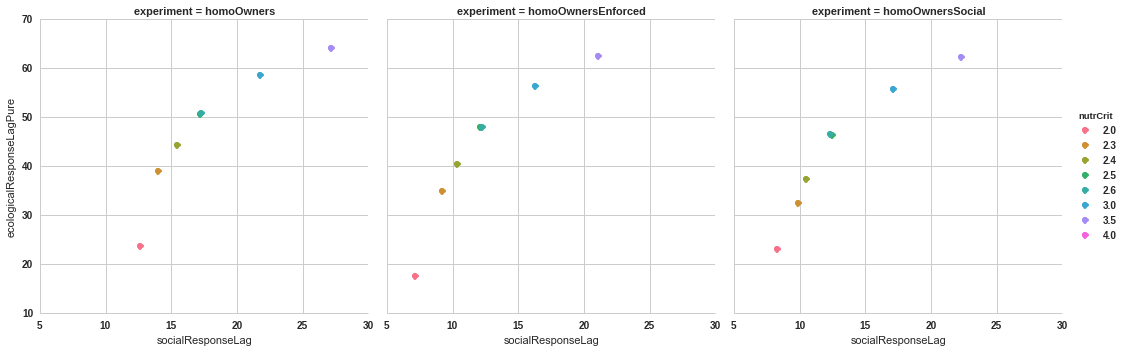

In [45]:
g = sns.FacetGrid(lags_nutr_grouped,  hue="nutrCrit", col = "experiment", size =5)
g = g.map(plt.plot, "socialResponseLag", "ecologicalResponseLagPure", marker='o', linestyle = '')
g.add_legend()

In [57]:
lags_wtu = timelags.xs((2.5),level=('nutrCrit')).reset_index()

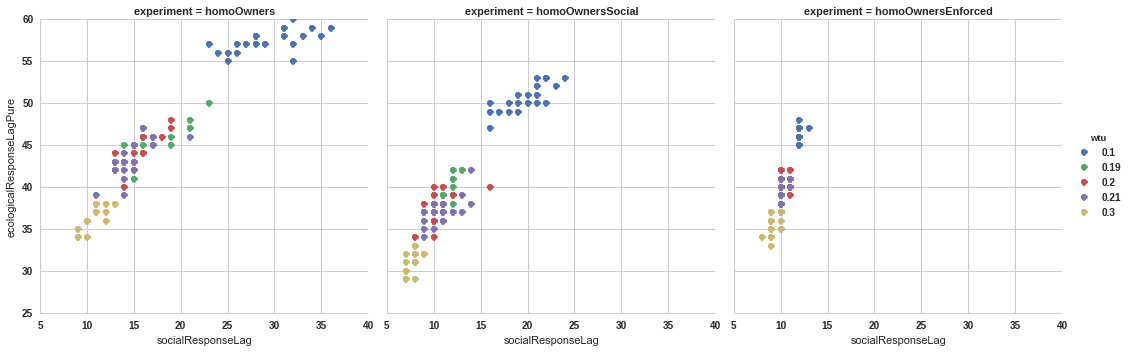

In [48]:
g = sns.FacetGrid(lags_wtu,  hue="wtu", col = "experiment", size =5)
g = g.map(plt.plot, "socialResponseLag", "ecologicalResponseLagPure", marker='o', linestyle = '')
g.add_legend()
#plt.savefig("images/NavigatingRSFig3b-pure.pdf")

In [49]:
timelags.groupby(level=('wtu','experiment','nutrCrit'))['yTip1'].count().reset_index()

wtu          experiment  nutrCrit  yTip1
0    0.10          homoOwners       2.0     20
1    0.10          homoOwners       2.3     10
2    0.10          homoOwners       2.4     20
3    0.10          homoOwners       2.5     20
4    0.10          homoOwners       2.6     20
5    0.10          homoOwners       3.0     20
6    0.10          homoOwners       3.5     20
7    0.10          homoOwners       4.0     20
8    0.10  homoOwnersEnforced       2.0     20
9    0.10  homoOwnersEnforced       2.3     10
10   0.10  homoOwnersEnforced       2.4     20
11   0.10  homoOwnersEnforced       2.5     20
12   0.10  homoOwnersEnforced       2.6     20
13   0.10  homoOwnersEnforced       3.0     20
14   0.10  homoOwnersEnforced       3.5     20
15   0.10  homoOwnersEnforced       4.0     20
16   0.10    homoOwnersSocial       2.0     20
17   0.10    homoOwnersSocial       2.3     10
18   0.10    homoOwnersSocial       2.4     20
19   0.10    homoOwnersSocial       2.5     20
20   0.10    homoOwnersSocial       2.6     20
21   0.10    homoOwnersSocial       3.0     20
22   0.10    homoOwnersSocial       3.5     20
23   0.10    homoOwnersSocial       4.0     20
24   0.19          homoOwners       2.0     20
25   0.19          homoOwners       2.3     10
26   0.19          homoOwners       2.4     20
27   0.19          homoOwners       2.5     20
28   0.19          homoOwners       2.6     20
29   0.19          homoOwners       3.0     20
..    ...                 ...       ...    ...
78   0.21    homoOwnersSocial       2.0     20
79   0.21    homoOwnersSocial       2.3     10
80   0.21    homoOwnersSocial       2.4     20
81   0.21    homoOwnersSocial       2.5     20
82   0.21    homoOwnersSocial       2.6     20
83   0.21    homoOwnersSocial       3.0     20
84   0.30          homoOwners       2.0     20
85   0.30          homoOwners       2.3     10
86   0.30          homoOwners       2.4     20
87   0.30          homoOwners       2.5     20
88   0.30          homoOwners       2.6     20
89   0.30          homoOwners       3.0     20
90   0.30          homoOwners       3.5     20
91   0.30          homoOwners       4.0     20
92   0.30  homoOwnersEnforced       2.0     20
93   0.30  homoOwnersEnforced       2.3     10
94   0.30  homoOwnersEnforced       2.4     20
95   0.30  homoOwnersEnforced       2.5     20
96   0.30  homoOwnersEnforced       2.6     20
97   0.30  homoOwnersEnforced       3.0     20
98   0.30  homoOwnersEnforced       3.5     20
99   0.30  homoOwnersEnforced       4.0     20
100  0.30    homoOwnersSocial       2.0     20
101  0.30    homoOwnersSocial       2.3     10
102  0.30    homoOwnersSocial       2.4     20
103  0.30    homoOwnersSocial       2.5     20
104  0.30    homoOwnersSocial       2.6     20
105  0.30    homoOwnersSocial       3.0     20
106  0.30    homoOwnersSocial       3.5     20
107  0.30    homoOwnersSocial       4.0     20

[108 rows x 4 columns]

In [50]:
lags_grouped = timelags.xs((2.4),level=('nutrCrit')).groupby(level=('wtu','experiment')).mean().reset_index()
lags_grouped

wtu          experiment  yTip1  yInformed  yRestoredHalf  yRestored  \
0   0.10          homoOwners     15         17          24.25      44.25   
1   0.10  homoOwnersEnforced     15         17          23.45      27.05   
2   0.10    homoOwnersSocial     15         17          22.25      34.75   
3   0.19          homoOwners     15         17          20.80      31.50   
4   0.19  homoOwnersEnforced     15         17          20.45      25.35   
5   0.19    homoOwnersSocial     15         17          20.05      26.35   
6   0.20          homoOwners     15         17          20.60      30.45   
7   0.20  homoOwnersEnforced     15         17          20.50      25.35   
8   0.20    homoOwnersSocial     15         17          19.85      25.50   
9   0.21          homoOwners     15         17          20.25      29.85   
10  0.21  homoOwnersEnforced     15         17          20.45      25.15   
11  0.21    homoOwnersSocial     15         17          19.70      25.80   
12  0.30          homoOwners     15         17          19.15      25.55   
13  0.30  homoOwnersEnforced     15         17          19.35      24.10   
14  0.30    homoOwnersSocial     15         17          19.00      22.70   

    yTip2  yPikeBack  socialResponseLag  ecologicalResponseLagPure  \
0   51.15      81.60              29.25                      57.35   
1   43.40      69.75              12.05                      46.30   
2   45.35      72.85              19.75                      50.60   
3   42.05      66.00              16.50                      45.20   
4   39.65      60.30              10.35                      39.85   
5   39.35      59.15              11.35                      39.10   
6   41.45      64.95              15.45                      44.35   
7   39.85      60.85              10.35                      40.35   
8   38.45      57.25              10.50                      37.40   
9   41.05      63.55              14.85                      43.30   
10  39.45      59.85              10.15                      39.40   
11  38.45      56.75              10.80                      37.05   
12  37.95      55.35              10.55                      36.20   
13  37.75      54.60               9.10                      35.25   
14  36.35      50.10               7.70                      31.10   

    ecologicalResponseLag  
0                   37.35  
1                   42.70  
2                   38.10  
3                   34.50  
4                   34.95  
5                   32.80  
6                   34.50  
7                   35.50  
8                   31.75  
9                   33.70  
10                  34.70  
11                  30.95  
12                  29.80  
13                  30.50  
14                  27.40

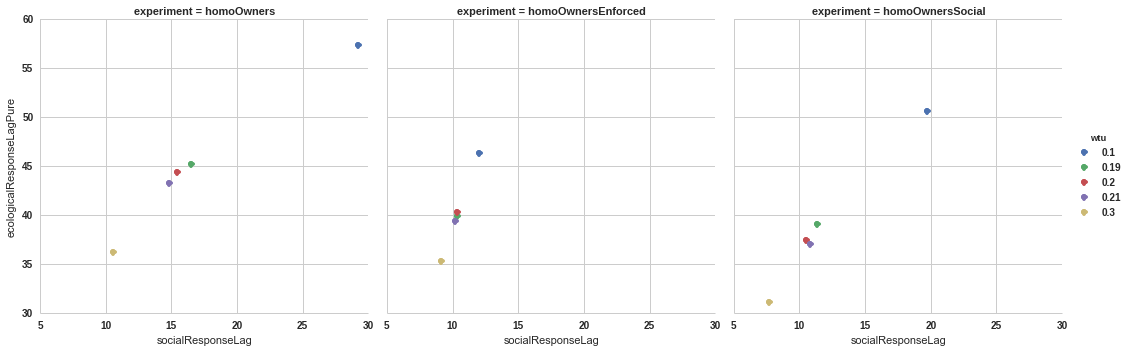

In [51]:
g = sns.FacetGrid(lags_grouped,  hue="wtu", col = "experiment", size =5)
g = g.map(plt.plot, "socialResponseLag", "ecologicalResponseLagPure", marker='o', linestyle = '')
g.add_legend()

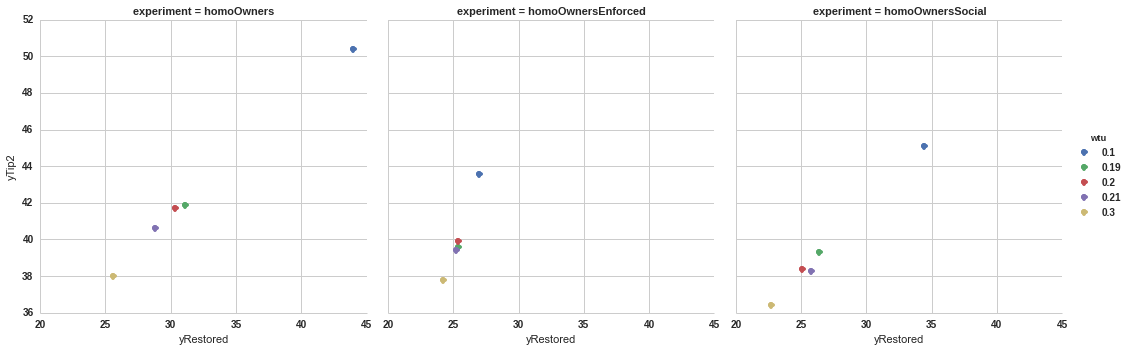

In [347]:
g = sns.FacetGrid(lags_grouped,  hue="wtu", col = "experiment", size =5)
g = g.map(plt.plot, "yRestored", "yTip2", marker='o', linestyle = '')
g.add_legend()

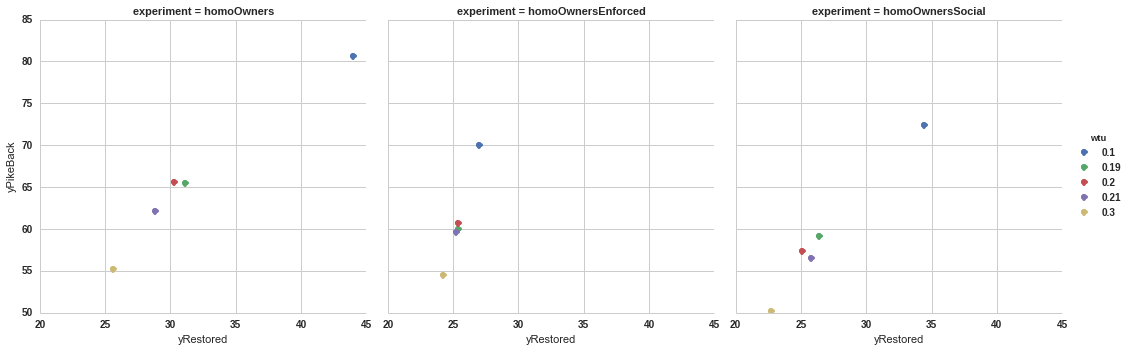

In [348]:
g = sns.FacetGrid(lags_grouped,  hue="wtu", col = "experiment", size =5)
g = g.map(plt.plot, "yRestored", "yPikeBack", marker='o', linestyle = '')
g.add_legend()

### Stacked bar chart for restoration time lags 

In [ ]:
#Plot 1 - background - "total" (top) series
sns.barplot(x = stacked_bar_data.Group, y = stacked_bar_data.total, color = "red")

#Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(x = stacked_bar_data.Group, y = stacked_bar_data.Series1, color = "#0000A3")

In [58]:
lags_wtu['total'] = lags_wtu.socialResponseLag + lags_wtu.ecologicalResponseLag
lags_nutr['total'] = lags_nutr.socialResponseLag + lags_nutr.ecologicalResponseLag

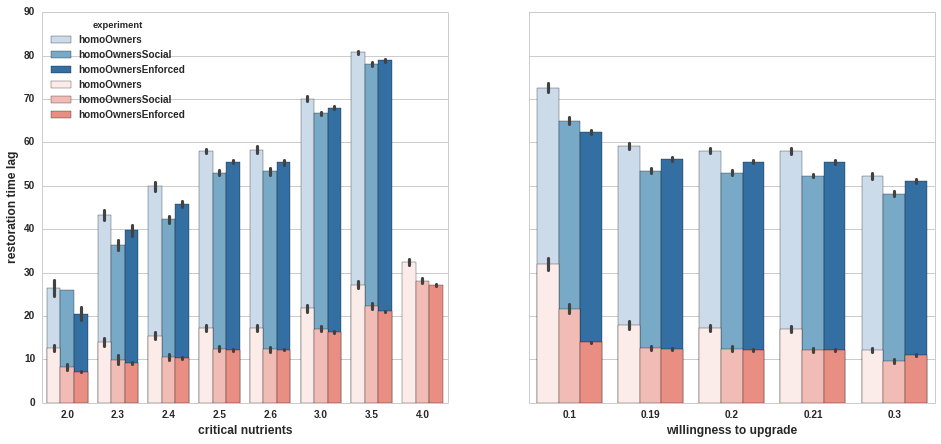

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,7))
sns.barplot(x = "nutrCrit", y = "total", hue="experiment", data = lags_nutr, palette="Blues", ax = ax1)
#g1.legend(title='Experiments', fontsize=12)
sns.barplot(x = "nutrCrit", y = "socialResponseLag", hue="experiment", data = lags_nutr, color = "salmon", ax=ax1)
ax1.set_ylabel('restoration time lag', fontsize = 12, fontweight = 'bold')
ax1.set_xlabel('critical nutrients', fontsize = 12, fontweight = 'bold')

sns.barplot(x = "wtu", y = "total", hue="experiment", data = lags_wtu, palette="Blues", ax = ax2)
sns.barplot(x = "wtu", y = "socialResponseLag", hue="experiment", data = lags_wtu, color = "salmon", ax = ax2)
ax2.legend('')
ax2.set_xlabel('willingness to upgrade', fontsize = 12, fontweight = 'bold')
ax2.set_ylabel('')
#plt.savefig("images/NavigatingRSFig3b.pdf")

###  Relative time lags table

In [60]:
lags_wtu.head()

level_0  run  wtu  experiment  yTip1  yInformed  yRestoredHalf  yRestored  \
0       50    1  0.1  homoOwners     15         19             26         45   
1       51    2  0.1  homoOwners     15         19             26         44   
2       52    3  0.1  homoOwners     15         19             28         48   
3       53    4  0.1  homoOwners     15         19             27         51   
4       54    5  0.1  homoOwners     15         19             26         45   

   yTip2  yPikeBack  socialResponseLag  ecologicalResponseLagPure  \
0     54         86                 30                         60   
1     54         85                 29                         59   
2     57         89                 33                         61   
3     58         89                 36                         62   
4     56         88                 30                         62   

   ecologicalResponseLag  total  
0                     41     71  
1                     41     70  
2                     41     74  
3                     38     74  
4                     43     73

Baseline - 100% values

In [84]:
social_wtu = timelags.xs((2.5, 0.2, 'homoOwners'),level=('nutrCrit', 'wtu', 'experiment')).socialResponseLag.mean()
eco_wtu = timelags.xs((2.5, 0.2, 'homoOwners'),level=('nutrCrit', 'wtu', 'experiment')).ecologicalResponseLag.mean()
social_wtu + eco_wtu

58.099999999999994

1st comparison: different strategies

In [80]:
e1 = timelags.xs((2.5, 0.2, 'homoOwnersSocial'),level=('nutrCrit', 'wtu', 'experiment')).ecologicalResponseLag.mean()
e2 = timelags.xs((2.5, 0.2, 'homoOwnersEnforced'),level=('nutrCrit', 'wtu', 'experiment')).ecologicalResponseLag.mean()
s1 = timelags.xs((2.5, 0.2, 'homoOwnersSocial'),level=('nutrCrit', 'wtu', 'experiment')).socialResponseLag.mean()
s2 = timelags.xs((2.5, 0.2, 'homoOwnersEnforced'),level=('nutrCrit', 'wtu', 'experiment')).socialResponseLag.mean()

In [ ]:
lags_wtu.socialResponseLag

In [85]:
(e1 * 100 / eco_wtu)-100

-0.73349633251832813

In [86]:
(e2 * 100 / eco_wtu)-100

6.2347188264058673

In [87]:
e1 + s1

53.049999999999997

In [88]:
e2 + s2

55.550000000000004

In [89]:
(s1 * 100 / social_wtu)-100

-27.616279069767444

In [90]:
(s2 * 100 / social_wtu)-100

-29.651162790697668

2nd comparison: lower wtu

In [91]:
e0 = timelags.xs((2.5, 0.1, 'homoOwners'),level=('nutrCrit', 'wtu', 'experiment')).ecologicalResponseLag.mean()
e1 = timelags.xs((2.5, 0.1, 'homoOwnersSocial'),level=('nutrCrit', 'wtu', 'experiment')).ecologicalResponseLag.mean()
e2 = timelags.xs((2.5, 0.1, 'homoOwnersEnforced'),level=('nutrCrit', 'wtu', 'experiment')).ecologicalResponseLag.mean()
s0 = timelags.xs((2.5, 0.1, 'homoOwners'),level=('nutrCrit', 'wtu', 'experiment')).socialResponseLag.mean()
s1 = timelags.xs((2.5, 0.1, 'homoOwnersSocial'),level=('nutrCrit', 'wtu', 'experiment')).socialResponseLag.mean()
s2 = timelags.xs((2.5, 0.1, 'homoOwnersEnforced'),level=('nutrCrit', 'wtu', 'experiment')).socialResponseLag.mean()

In [92]:
(e0 * 100 / eco_wtu)-100

-0.61124694376528055

In [93]:
(e1* 100 / eco_wtu)-100

6.1124694376528197

In [94]:
(e2 * 100 / eco_wtu)-100

18.215158924205383

In [95]:
(s0 * 100 / social_wtu)-100

85.755813953488371

In [96]:
(s1 * 100 / social_wtu)-100

25.581395348837219

In [97]:
(s2 * 100 / social_wtu)-100

-18.895348837209298

3rd comparison: higher wtu

In [98]:
e0 = timelags.xs((2.5, 0.3, 'homoOwners'),level=('nutrCrit', 'wtu', 'experiment')).ecologicalResponseLag.mean()
e1 = timelags.xs((2.5, 0.3, 'homoOwnersSocial'),level=('nutrCrit', 'wtu', 'experiment')).ecologicalResponseLag.mean()
e2 = timelags.xs((2.5, 0.3, 'homoOwnersEnforced'),level=('nutrCrit', 'wtu', 'experiment')).ecologicalResponseLag.mean()
s0 = timelags.xs((2.5, 0.3, 'homoOwners'),level=('nutrCrit', 'wtu', 'experiment')).socialResponseLag.mean()
s1 = timelags.xs((2.5, 0.3, 'homoOwnersSocial'),level=('nutrCrit', 'wtu', 'experiment')).socialResponseLag.mean()
s2 = timelags.xs((2.5, 0.3, 'homoOwnersEnforced'),level=('nutrCrit', 'wtu', 'experiment')).socialResponseLag.mean()

### Relative time lags plot

In [54]:
lags_grouped['total'] = lags_grouped.socialResponseLag + lags_grouped.ecologicalResponseLag
lags_grouped['socialPart'] = lags_grouped.socialResponseLag * 100 / lags_grouped.total

In [55]:
lags_nutr_grouped['total'] = lags_nutr_grouped.socialResponseLag + lags_nutr_grouped.ecologicalResponseLag
lags_nutr_grouped['socialPart'] = lags_nutr_grouped.socialResponseLag * 100 / lags_nutr_grouped.total

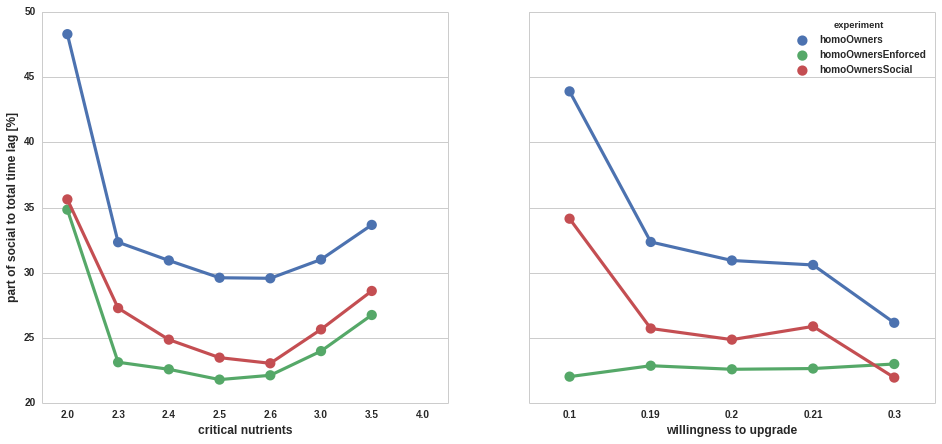

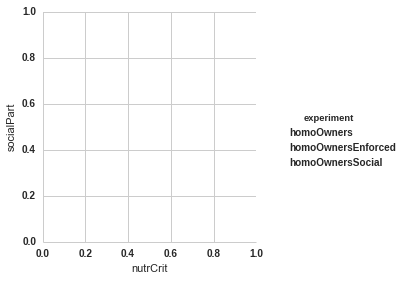

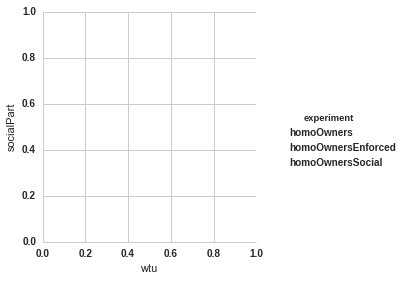

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,7))
g1 = sns.factorplot(x="nutrCrit", y="socialPart", hue="experiment", data=lags_nutr_grouped, ax = ax1)
g2 = sns.factorplot(x="wtu", y="socialPart", hue="experiment", data=lags_grouped, ax = ax2)

ax1.set_ylabel('part of social to total time lag [%]', fontsize = 12, fontweight = 'bold')
ax1.set_xlabel('critical nutrients', fontsize = 12, fontweight = 'bold')
ax2.set_ylabel('')
ax2.set_xlabel('willingness to upgrade', fontsize = 12, fontweight = 'bold')
ax1.legend('')
#fig.savefig("images/NavigatingRSFig3c.pdf")

##  Quantifying restoration success - attempt 2 

In difference to the previous version, I select only a subset of scenarios that enable to interprete the sensitivity of parameters and strength of feedbacks at the same time.

In [40]:
lags_wtu = timelags.xs((2.5),level=('nutrCrit')).reset_index()
lags_nutr = timelags.xs((0.2),level=('wtu')).reset_index()

lags_wtu_sub = lags_wtu[(lags_wtu.wtu == 0.1) | (lags_wtu.wtu == 0.2) |
                       (lags_wtu.wtu == 0.3)]
lags_nutr_sub = lags_nutr[(lags_nutr.nutrCrit == 2.0) | (lags_nutr.nutrCrit == 2.5) |
                       (lags_nutr.nutrCrit == 3.0) ]

In [41]:
lags_wtu_sub['total'] = lags_wtu_sub.socialResponseLag + lags_wtu_sub.ecologicalResponseLag
lags_nutr_sub['total'] = lags_nutr_sub.socialResponseLag + lags_nutr_sub.ecologicalResponseLag

/home/romina/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [42]:
lags_nutr_sub.head(10)

level_0  run  experiment  nutrCrit  yTip1  yInformed  yRestoredHalf  \
0       90    1  homoOwners         2     15         14             17   
1       91    2  homoOwners         2     15         14             18   
2       92    3  homoOwners         2     15         14             17   
3       93    4  homoOwners         2     15         14             18   
4       94    5  homoOwners         2     15         14             17   
5       95    6  homoOwners         2     15         14             18   
6       96    7  homoOwners         2     15         14             17   
7       97    8  homoOwners         2     15         14             17   
8       98    9  homoOwners         2     15         14             18   
9       99   10  homoOwners         2     15         14             17   

   yRestored  yTip2  yPikeBack  socialResponseLag  ecologicalResponseLagPure  \
0         26     34        NaN                 11                        NaN   
1         27     36         45                 12                         27   
2         26     35         38                 11                         21   
3         26     36         43                 11                         25   
4         26     35         40                 11                         23   
5         26     36         43                 11                         25   
6         29     35         40                 14                         23   
7         28     36         42                 13                         25   
8         28     36         46                 13                         28   
9         26     34        NaN                 11                        NaN   

   ecologicalResponseLag  total  
0                    NaN    NaN  
1                     18     30  
2                     12     23  
3                     17     28  
4                     14     25  
5                     17     28  
6                     11     25  
7                     14     27  
8                     18     31  
9                    NaN    NaN

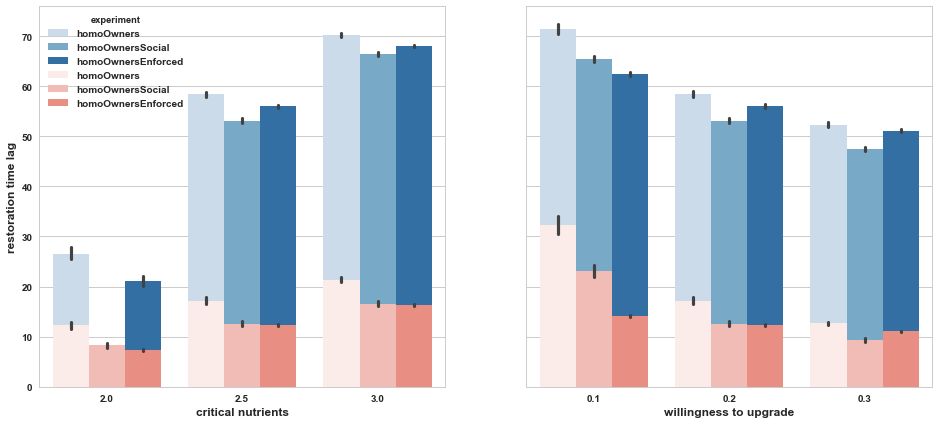

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,7))
sns.barplot(x = "nutrCrit", y = "total", hue="experiment", data = lags_nutr_sub, palette="Blues", ax = ax1)
#g1.legend(title='Experiments', fontsize=12)
sns.barplot(x = "nutrCrit", y = "socialResponseLag", hue="experiment", data = lags_nutr_sub, color = "salmon", ax=ax1)
ax1.set_ylabel('restoration time lag', fontsize = 12, fontweight = 'bold')
ax1.set_xlabel('critical nutrients', fontsize = 12, fontweight = 'bold')

sns.barplot(x = "wtu", y = "total", hue="experiment", data = lags_wtu_sub, palette="Blues", ax = ax2)
sns.barplot(x = "wtu", y = "socialResponseLag", hue="experiment", data = lags_wtu_sub, color = "salmon", ax = ax2)
ax2.legend('')
ax2.set_xlabel('willingness to upgrade', fontsize = 12, fontweight = 'bold')
ax2.set_ylabel('')
plt.savefig("NavigatingRSFig3b_2018.pdf")

In [44]:
lags_grouped = timelags.xs((2.5),level=('nutrCrit')).groupby(level=('wtu','experiment')).mean().reset_index()
lags_nutr_grouped = timelags.xs((0.2),level=('wtu')).groupby(level=('nutrCrit','experiment')).mean().reset_index()
lags_grouped['total'] = lags_grouped.socialResponseLag + lags_grouped.ecologicalResponseLag
lags_grouped['socialPart'] = lags_grouped.socialResponseLag * 100 / lags_grouped.total
lags_nutr_grouped['total'] = lags_nutr_grouped.socialResponseLag + lags_nutr_grouped.ecologicalResponseLag
lags_nutr_grouped['socialPart'] = lags_nutr_grouped.socialResponseLag * 100 / lags_nutr_grouped.total
lags_grouped_wtu_sub = lags_grouped[(lags_grouped.wtu == 0.1) | (lags_grouped.wtu == 0.2) |
                       (lags_grouped.wtu == 0.3)]
lags_grouped_nutr_sub = lags_nutr_grouped[(lags_nutr_grouped.nutrCrit == 2.0) | (lags_nutr_grouped.nutrCrit == 2.5) |
                       (lags_nutr_grouped.nutrCrit == 3.0)]

AttributeError: 'FacetGrid' object has no attribute 'lines'

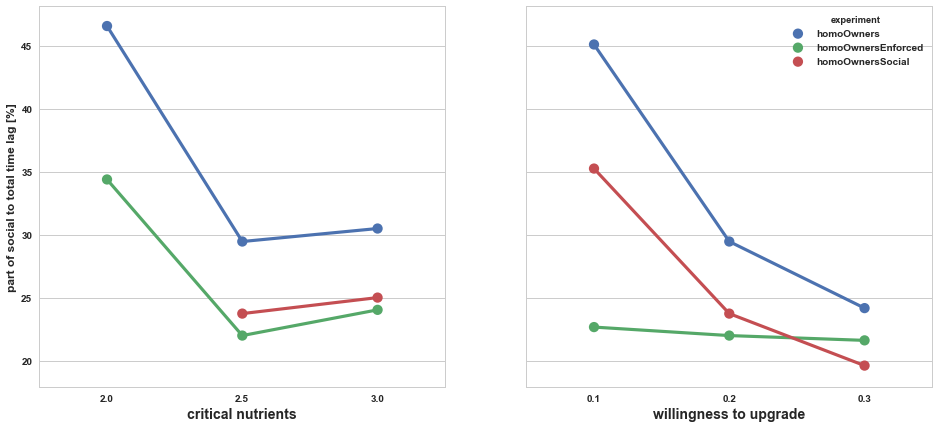

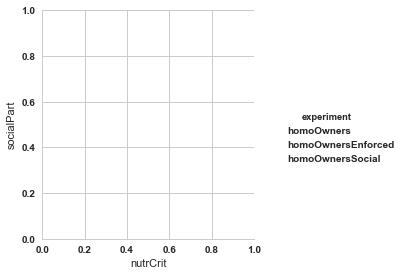

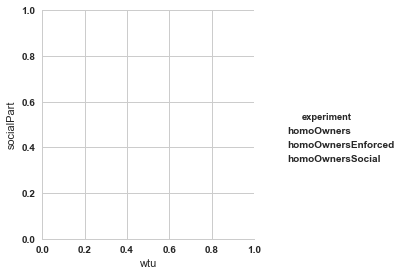

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,7))
g1 = sns.factorplot(x="nutrCrit", y="socialPart", hue="experiment", data=lags_grouped_nutr_sub, ax = ax1)
g2 = sns.factorplot(x="wtu", y="socialPart", hue="experiment", data=lags_grouped_wtu_sub, ax = ax2)

ax1.set_ylabel('part of social to total time lag [%]', fontsize = 12, fontweight = 'bold')
ax1.set_xlabel('critical nutrients', fontsize = 14, fontweight = 'bold')
ax2.set_ylabel('')
ax2.set_xlabel('willingness to upgrade', fontsize = 14, fontweight = 'bold')
ax1.legend('')

fig.savefig("NavigatingRSFig3c_2018.pdf")
g1.lines[-1].set_marker("v")
g1.lines[1].set_marker("o")
g1.lines[0].set_marker("d")
g1.lines[0].set_linestyle(":")
g1.lines[-1].set_linestyle("--")


### Check combined effect of threshold and wtu increase

Can improvement of social pressure mechanism counteract a delay in communal decision making?

In [128]:
lags_wtu = timelags.xs((3.0),level=('nutrCrit')).reset_index()

In [129]:
lags_wtu_sub = lags_wtu[(lags_wtu.wtu == 0.1) | (lags_wtu.wtu == 0.2) |
                       (lags_wtu.wtu == 0.3)]

In [130]:
lags_wtu_sub['total'] = lags_wtu_sub.socialResponseLag + lags_wtu_sub.ecologicalResponseLag

/home/romina/.local/lib/python3.4/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


TypeError: 'AxesSubplot' object is not iterable

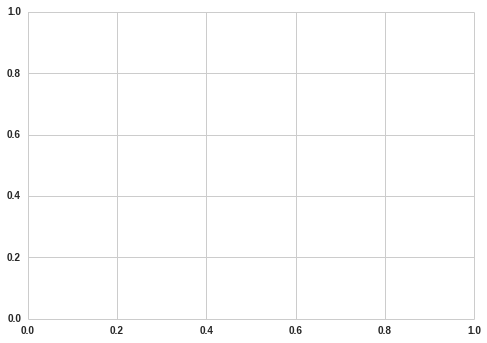

In [135]:
fig, ax1 = plt.subplot()
sns.barplot(x = "wtu", y = "total", hue="experiment", data = lags_wtu_sub, palette="Blues", ax = ax1)
sns.barplot(x = "wtu", y = "socialResponseLag", hue="experiment", data = lags_wtu_sub, color = "salmon", ax = ax1)
ax1.legend('')
ax1.set_xlabel('willingness to upgrade', fontsize = 12, fontweight = 'bold')
ax1.set_ylabel('')
